In [1]:
import  numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from system_utils import *
import pandas as pd
plt.rcParams['text.usetex'] = True

In [2]:
%run system_utils.py
init_params={
    'v' : 10,                    # Wave speed
    'theta_resolution' : 1,     # degrees
    'tolerance' : 0.05,         # Detection threshold
    'r_s' :     50,                # r of source
    'theta_s' : np.deg2rad(60) ,      # theta of source
    'd': 20,       #rescale with r_s*     # radially symmetric receptor positions
    'r1_amp':25,                 # amplitude of outR1
    'r2_amp':25,                  # amplitude of outR2
    'r1_theta': 0,
    'r2_theta': np.pi,
    }
init_params.update({'R1cart':polar2cart(init_params['d'], init_params['r1_theta']),
                    'R2cart':polar2cart(-init_params['d'], init_params['r2_theta']),
                    'Scart': polar2cart(init_params['r_s'],init_params['r_s'] ),
                    })

# init_params=ReceptorUpdate(init_params)

time_params = {
    'dt' : 0.01,                # Time step
    'tmax' : 100,              # Simulation duration
    'pulses' : 10,               # Period between source emissions
    'width' : 100,               # time width of pulse window
}
interneuron ={
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 1e3,  # refractory phase
    'w1': 6.5,
    'w2': 6.5, 
    'tau': 1,
    'outA': 25,  #amplitude of out current;
    'I1':'outR1',#ID of first current input
    'I2':'outR2'
}
outneuron1 = {
    'id':'O1',
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 200,  # refractory phase
    'w1': 5,
    'w2': 30,
    'tau': 1,
    'outA': 20,  #amplitude of out current;
    'I1':'outR1',#ID of first current input
    'I2':'outI'
}
outneuron2 = {
    'id':'O2',
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 200,  # refractory phase
    'w1': 5,
    'w2': 30,
    'tau': 1,
    'outA': 20,  #amplitude of out current;
    'I1':'outR2',#ID of first current input
    'I2':'outI'   
}


In [3]:
init_params

{'v': 10,
 'theta_resolution': 1,
 'tolerance': 0.05,
 'r_s': 50,
 'theta_s': 1.0471975511965976,
 'd': 20,
 'r1_amp': 25,
 'r2_amp': 25,
 'r1_theta': 0,
 'r2_theta': 3.141592653589793,
 'R1cart': array([20.,  0.]),
 'R2cart': array([ 2.0000000e+01, -2.4492936e-15]),
 'Scart': array([ 48.24830142, -13.11874269])}

In [ ]:
%run system_utils.py
time = np.arange(0, time_params['tmax'], time_params['dt'])
N = len(time)

# Initialize df with zeros
df = pd.DataFrame({'time': time,
                    'outS': np.zeros(N),
                    'outR1': np.zeros(N),
                    'outR2': np.zeros(N),
                    'outI': np.zeros(N),
                    'outO1': np.zeros(N),
                    'outO2': np.zeros(N)})
# Precompute emission times and mark in df
emission_times, S_out, _ = PeriodicEmissionW(time, time_params)
df['outS'] = S_out

# Initialize membrane potentials and refractory counters for interneuron and output neurons
V_int = np.full(N, interneuron['V0'])
rfcount_int = 0

V_O1 = np.full(N, outneuron1['V0'])
rfcount_O1 = 0

V_O2 = np.full(N, outneuron2['V0'])
rfcount_O2 = 0

location = []
theta_log = []
for i in tqdm(range(1, N)):
    t_i = time[i]
    
    # 1. Calculate receptor hits at this time (wavefronts hitting receptor)
    for t_emit in emission_times:
        if t_i < t_emit:# add lowerbound?
            continue
        r_wave = init_params['v'] * (t_i - t_emit)
        # Check distance receptor 1 and 2
        dist1 = np.linalg.norm(init_params['R1cart'] - init_params['Scart'])
        dist2 = np.linalg.norm(init_params['R2cart'] - init_params['Scart'])
        if abs(r_wave - dist1) < init_params['tolerance']:
            df.at[i, 'outR1'] = init_params['r1_amp']
        if abs(r_wave - dist2) < init_params['tolerance']:
            df.at[i, 'outR2'] = init_params['r2_amp']
    
    # 2. Update interneuron LIF
    if rfcount_int > 0:
        V_int[i] = interneuron['V0']
        rfcount_int -= 1
    else:
        I1 = df.at[i, 'outR1']
        I2 = df.at[i, 'outR2']
        dV = (interneuron['V0'] - V_int[i-1] + interneuron['w1']*I1 + interneuron['w2']*I2) / interneuron['tau']
        V_int[i] = V_int[i-1] + time_params['dt'] * dV
        if V_int[i] >= interneuron['Vq']:
            V_int[i] = interneuron['V0']
            rfcount_int = interneuron['rft']
    
    df.at[i, 'outI'] = interneuron['outA'] if V_int[i] >= -56 else 0
    
    # 3. Update output neurons O1 and O2 similarly
    # O1
    if rfcount_O1 > 0:
        V_O1[i] = outneuron1['V0']
        rfcount_O1 -= 1
    else:
        I1 = df.at[i, 'outR1']
        I2 = df.at[i, 'outI']
        dV = (outneuron1['V0'] - V_O1[i-1] + outneuron1['w1']*I1 + outneuron1['w2']*I2) / outneuron1['tau']
        V_O1[i] = V_O1[i-1] + time_params['dt'] * dV
        if V_O1[i] >= outneuron1['Vq']:
            V_O1[i] = outneuron1['V0']
            rfcount_O1 = outneuron1['rft']
    
    df.at[i, 'outO1'] = outneuron1['outA'] if V_O1[i] >= -56 else 0
    
    # O2
    eulerLIF(outneuron2,'ourR2', 'outI',  rfcount_O2)
    # if rfcount_O2 > 0:
    #     V_O2[i] = outneuron2['V0']
    #     rfcount_O2 -= 1
    # else:
    #     I1 = df.at[i, 'outR2']
    #     I2 = df.at[i, 'outI']
    #     dV = (outneuron2['V0'] - V_O2[i-1] + outneuron2['w1']*I1 + outneuron2['w2']*I2) / outneuron2['tau']
    #     V_O2[i] = V_O2[i-1] + time_params['dt'] * dV
    #     if V_O2[i] >= outneuron2['Vq']:
    #         V_O2[i] = outneuron2['V0']
    #         rfcount_O2 = outneuron2['rft']
    
    # df.at[i, 'outO2'] = outneuron2['outA'] if V_O2[i] >= -56 else 0
    
    # 4. Infer firing dynamically
    O1_fire = True if df.at[i, 'outO1'] > 0 else False
    O2_fire = True if df.at[i, 'outO2'] > 0 else False
    location.append([O1_fire, O2_fire])
    
    # 5. Update theta_s dynamically if needed (only if firing state changed)
    if i > 1 and location[-1] != location[-2]:
        new_init_params = thetaUpdation(location, init_params, theta_log)
        if new_init_params is not None:
            init_params = new_init_params
    


  5%|▍         | 473/9999 [00:00<00:10, 888.19it/s]

O1 and O2 are True.


  6%|▋         | 642/9999 [00:00<00:12, 752.64it/s]D:\IMSc coursework\Brain, Dynamics and Computation\Acoustic-Localisation-BDC25\system_utils.py:93: PredictionWarning: Failed in prediction
  warnings.warn('Failed in prediction', PredictionWarning)
100%|██████████| 9999/9999 [00:44<00:00, 225.64it/s]


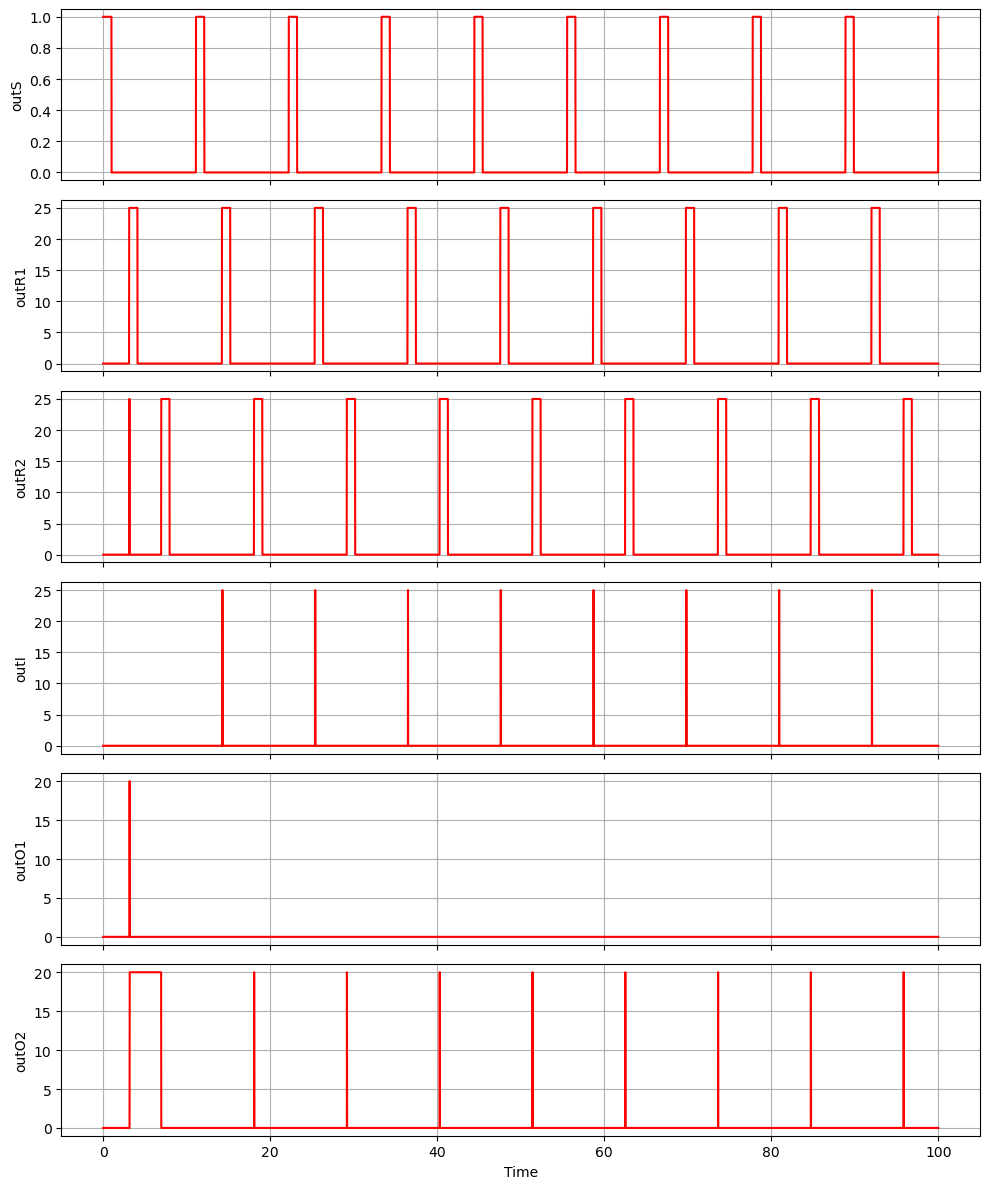

In [5]:
%run system_utils.py
dfPlot(df)

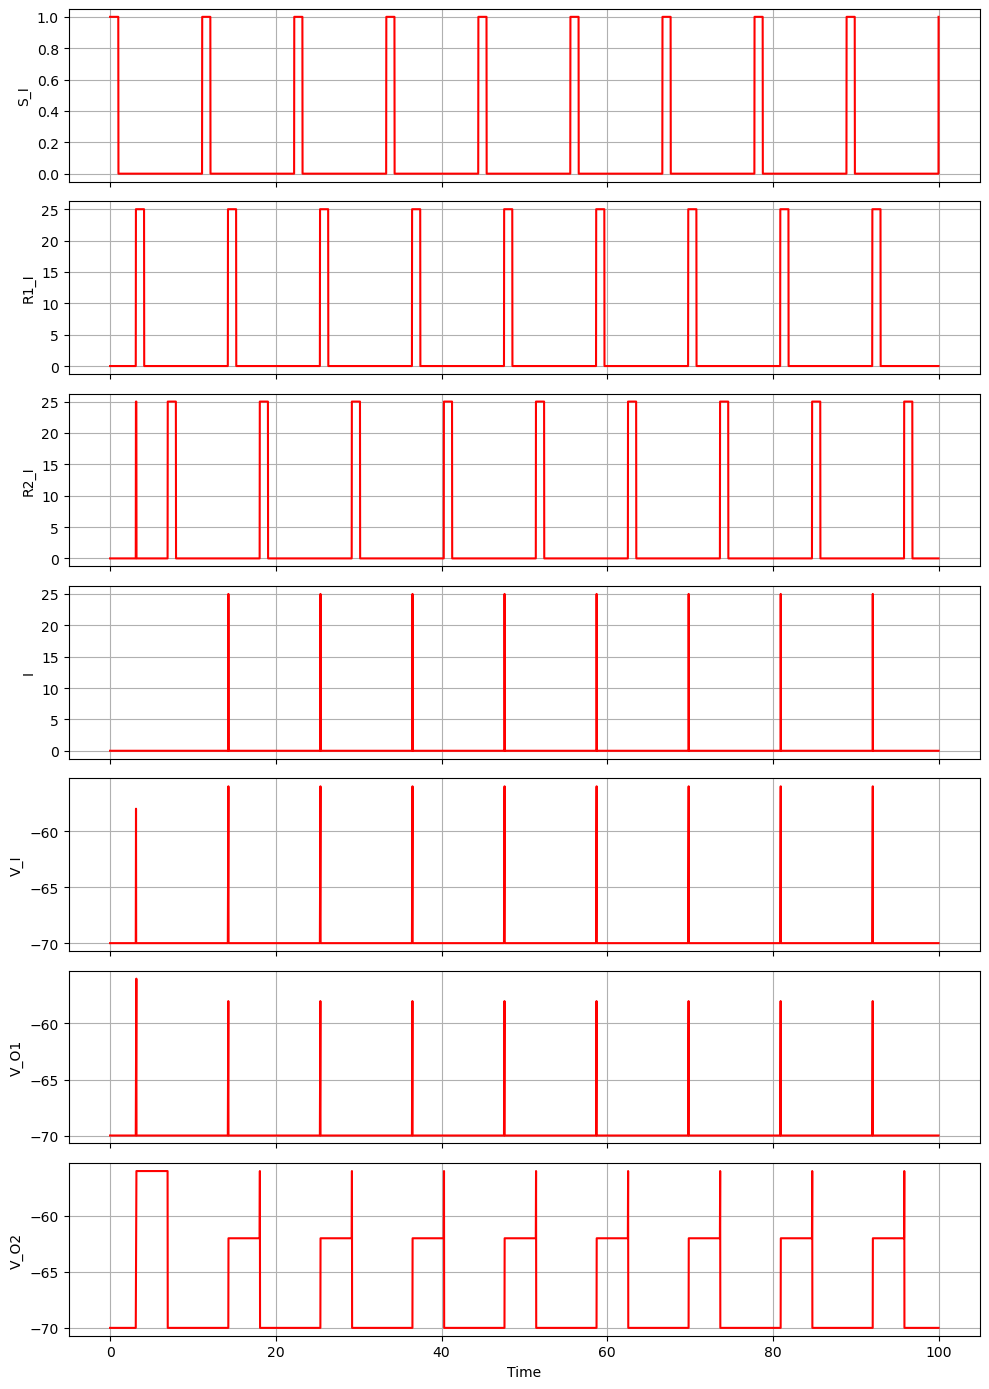

In [7]:
%run system_utils.py
Vdf = pd.DataFrame({
        'time':time,
        'S_I':S_out,
        'R1_I':df['outR1'],
        'R2_I':df['outR2'],
        'I': df['outI'],
        'V_I':V_int,
        'V_O1':V_O1,
        'V_O2':V_O2,
    })
dfPlot(Vdf)

In [6]:
Vdf

NameError: name 'Vdf' is not defined

In [ ]:
# %run utils.py
# initDF, strtIdx, emission = FirstRun(time_params)
# megaDF = pd.DataFrame()
# location = []
# for j in range(1, len(strtIdx)):
#     newSout = initDF.iloc[strtIdx[j-1]: strtIdx[j],:]['outS']
#     newtime = initDF.iloc[strtIdx[j-1]: strtIdx[j],:]['time']
#     holdf,holdVdf, instant_location = FindSource(newtime, newSout, emission,
#                 time_params, init_params,
#                 interneuron, outneuron1, outneuron2)
#     location.append(instant_location)
#     megaDF = pd.concat([megaDF,holdf], ignore_index=True)
    
#     init_params = thetaUpdation(location, init_params)
    # dfPlot(holdf)
